In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog, canny
from skimage.filters import sobel, gabor
from skimage import data
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from skimage.measure import regionprops
from skimage.morphology import disk
from scipy.fft import fft2, fftshift
from sklearn.decomposition import PCA
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

In [3]:
# Load Image
img_path = './assets/butterfly.jpg'  # Replace with your image path
img = cv2.imread(img_path)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [5]:
# Display feature extractions
def display_image(img, title):
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.colorbar()
    plt.show()

# Helper Functions 


In [4]:
# Gabor Filter
def gabor_features(image, frequency=0.6):
    filtered_real, filtered_imag = gabor(image, frequency=frequency)
    return filtered_real

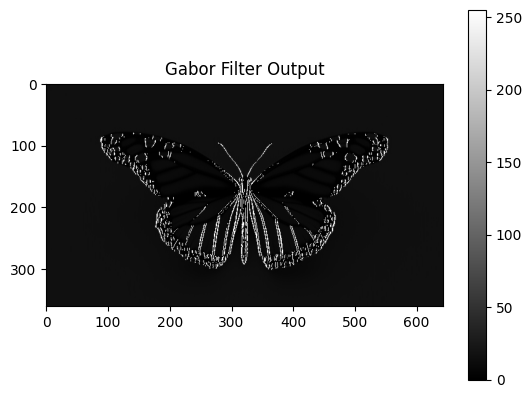

In [7]:
# 1. Gabor Filter
gabor_img = gabor_features(gray_img)
display_image(gabor_img, "Gabor Filter Output")

In [8]:
# Sobel Edge Detection
def sobel_features(image):
    edges = sobel(image)
    return edges

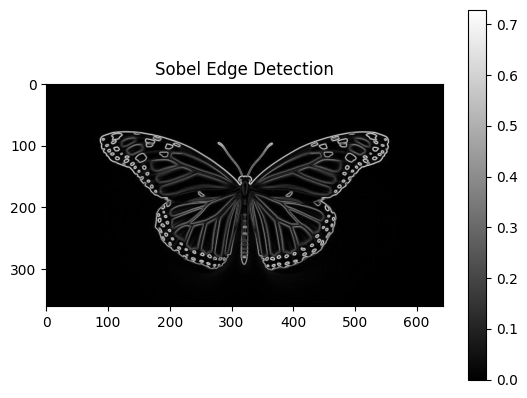

In [9]:
# 2. Sobel Edge Detection
sobel_img = sobel_features(gray_img)
display_image(sobel_img, "Sobel Edge Detection")

In [10]:
# Histogram of Oriented Gradients (HOG)
def hog_features(image):
    features, hog_img = hog(image, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True, channel_axis=None)
    return features, hog_img

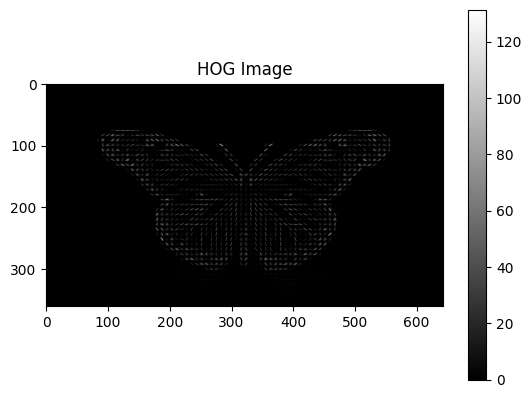

In [11]:
# 3. Histogram of Oriented Gradients (HOG)
_, hog_img = hog_features(gray_img)
display_image(hog_img, "HOG Image")

In [12]:
# Canny Edge Detection
def canny_features(image):
    edges = canny(image)
    return edges

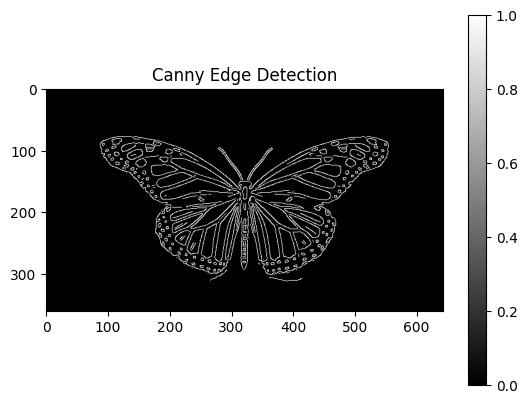

In [13]:
# 4. Canny Edge Detection
canny_img = canny_features(gray_img)
display_image(canny_img, "Canny Edge Detection")

In [14]:
# Local Binary Pattern (LBP)
def lbp_features(image):
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    return lbp

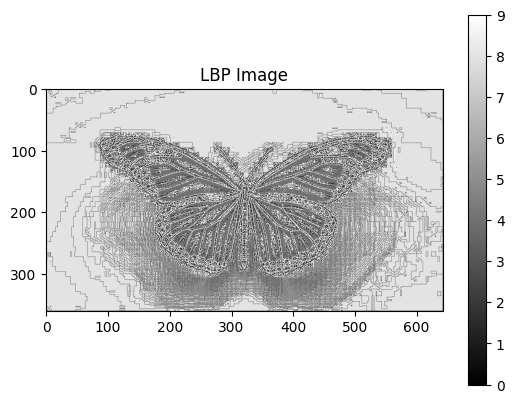

In [15]:
# 5. Local Binary Pattern (LBP)
lbp_img = lbp_features(gray_img)
display_image(lbp_img, "LBP Image")

In [16]:
# Gaussian Blur
def gaussian_blur(image, kernel_size=5):
    blurred_img = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return blurred_img

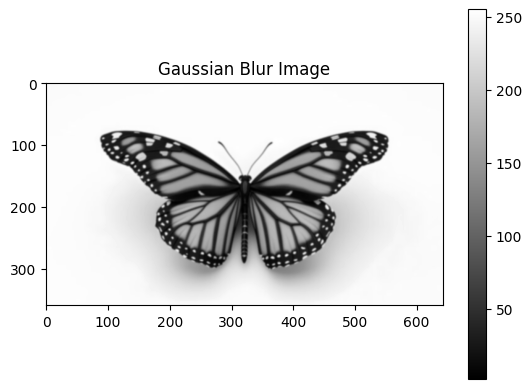

In [17]:
 #6. Gaussian Blur
blurred_img = gaussian_blur(gray_img)
display_image(blurred_img, "Gaussian Blur Image")

In [ ]:
# FAST Corner Detection
def fast_corner_detection(image):
    fast = cv2.FastFeatureDetector_create()
    keypoints = fast.detect(image, None)
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(255, 0, 0))
    return img_with_keypoints

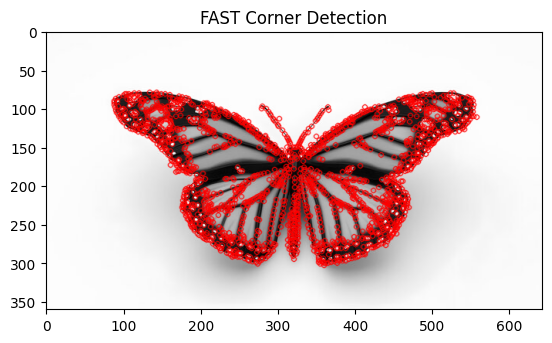

In [18]:
# 7. FAST Corner Detection
fast_img = fast_corner_detection(gray_img)
plt.figure()
plt.title("FAST Corner Detection")
plt.imshow(fast_img)
plt.show()

In [19]:
# SIFT Features (Scale-Invariant Feature Transform)
def sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
    return img_with_keypoints

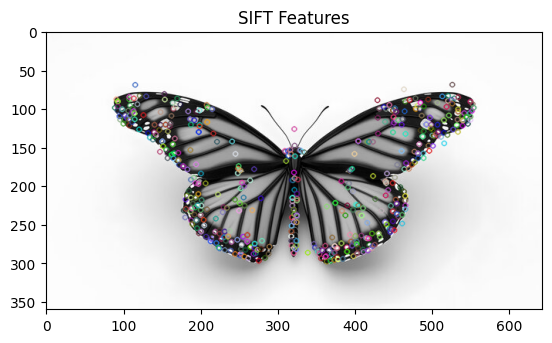

In [20]:
# 8. SIFT Features
sift_img = sift_features(gray_img)
plt.figure()
plt.title("SIFT Features")
plt.imshow(sift_img)
plt.show()

In [21]:
# ORB Features (Oriented FAST and Rotated BRIEF)
def orb_features(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0))
    return img_with_keypoints

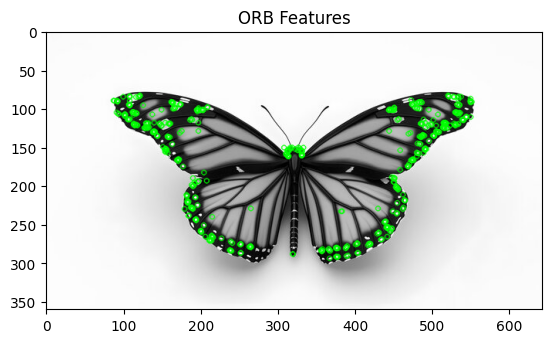

In [22]:
# 9. ORB Features
orb_img = orb_features(gray_img)
plt.figure()
plt.title("ORB Features")
plt.imshow(orb_img)
plt.show()

In [23]:
# K-means Clustering for Color Segmentation
def kmeans_clustering(image, k=3):
    # Reshaping image to 2D for K-means
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    return segmented_image

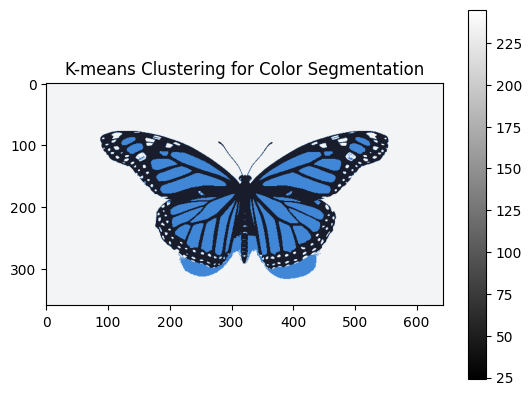

In [24]:
# 10. K-means Clustering for Color Segmentation
kmeans_img = kmeans_clustering(img)
display_image(kmeans_img, "K-means Clustering for Color Segmentation")

In [25]:
# Laplacian of Gaussian (LOG)
def log_features(image, ksize=5):
    log_img = cv2.Laplacian(image, cv2.CV_64F, ksize=ksize)
    return log_img


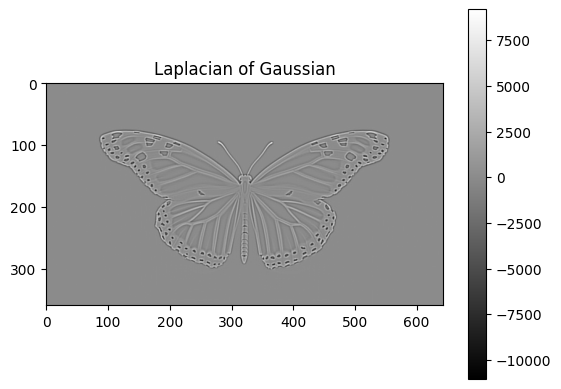

In [26]:
# 11. Laplacian of Gaussian (LOG)
log_img = log_features(gray_img)
display_image(log_img, "Laplacian of Gaussian")

In [27]:
# ------------------------------- CNN Features Extraction -------------------------------

# Load VGG16 model pre-trained on ImageNet
model = VGG16(weights='imagenet', include_top=False, pooling='avg')  # Use average pooling to get feature vector

# Function to extract features using CNN (VGG16)
def extract_cnn_features(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))  # Resize image to 224x224
    img_data = image.img_to_array(img)  # Convert image to array
    
    # If the image is grayscale (single channel), convert it to 3 channels (RGB)
    if len(img_data.shape) == 3 and img_data.shape[-1] == 1:  # Check if the image has 1 channel
        img_data = np.repeat(img_data, 3, axis=-1)  # Convert grayscale to RGB
    
    img_data = np.expand_dims(img_data, axis=0)  # Add batch dimension
    img_data = preprocess_input(img_data)  # Preprocess the image for VGG16
    
    # Extract features
    features = model.predict(img_data)
    
    return features.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


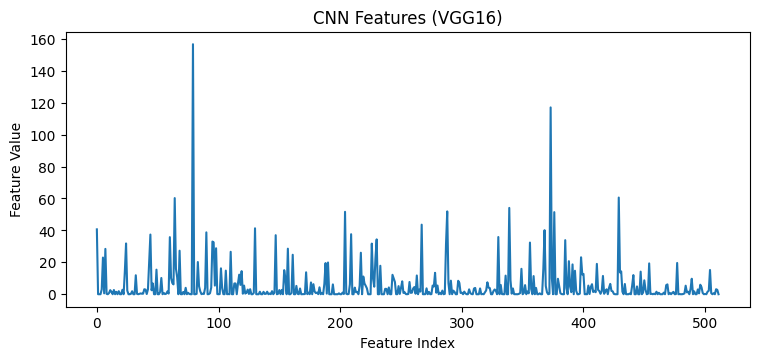

Shape of extracted CNN features: (512,)


In [42]:
cnn_features = extract_cnn_features(img_path)

# Plot the extracted CNN features
plt.figure(figsize=(30, 25))
plt.subplot(6, 3, 6)
plt.title("CNN Features (VGG16)")
plt.plot(cnn_features.flatten())
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

# Print the shape of extracted features
print("Shape of extracted CNN features:", cnn_features.shape)


In [32]:
# Load MobileNet model pre-trained on ImageNet
mobilenet_model = MobileNet(weights='imagenet', include_top=False, pooling='avg')  # Use average pooling to get feature vector

# Function to extract features using MobileNet
def extract_mobilenet_features(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Resize image to 224x224
    img_data = image.img_to_array(img)  # Convert image to array
    img_data = np.expand_dims(img_data, axis=0)  # Add batch dimension
    img_data = preprocess_input(img_data)  # Preprocess the image for MobileNet
    
    # Extract features
    features = mobilenet_model.predict(img_data)
    
    return features.flatten()

C:\Users\USER\AppData\Local\Temp\ipykernel_18180\436773240.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNet(weights='imagenet', include_top=False, pooling='avg')  # Use average pooling to get feature vector


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 21s 1us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


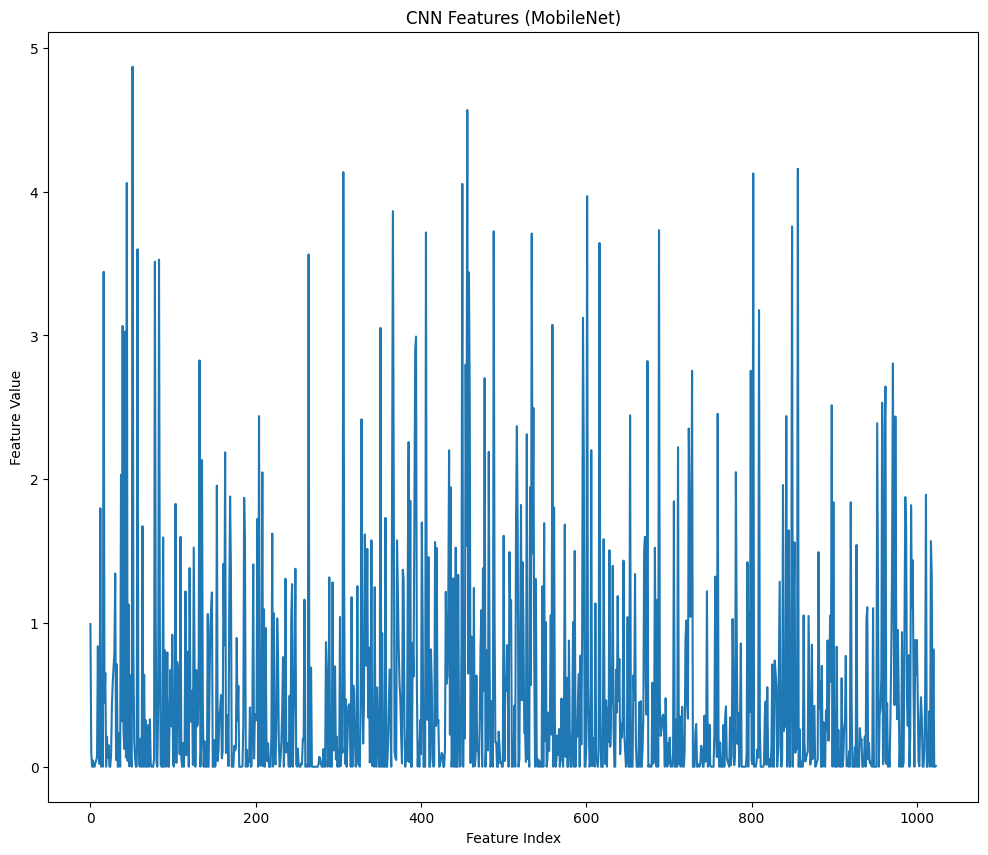

Shape of extracted MobileNet features: (1024,)


In [33]:
mobilenet_features = extract_mobilenet_features(img_path)

# Plot the extracted MobileNet features
plt.figure(figsize=(12, 10))
plt.title("CNN Features (MobileNet)")
plt.plot(mobilenet_features.flatten())
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

# Print the shape of extracted features
print("Shape of extracted MobileNet features:", mobilenet_features.shape)

In [39]:
# Load ResNet50 model pre-trained on ImageNet
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features using ResNet50
def extract_resnet_features(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Resize image to 224x224
    img_data = image.img_to_array(img)  # Convert image to array
    img_data = np.expand_dims(img_data, axis=0)  # Add batch dimension
    img_data = preprocess_input(img_data)  # Preprocess the image for ResNet50
    
    # Extract features
    features = resnet_model.predict(img_data)
    
    return features.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


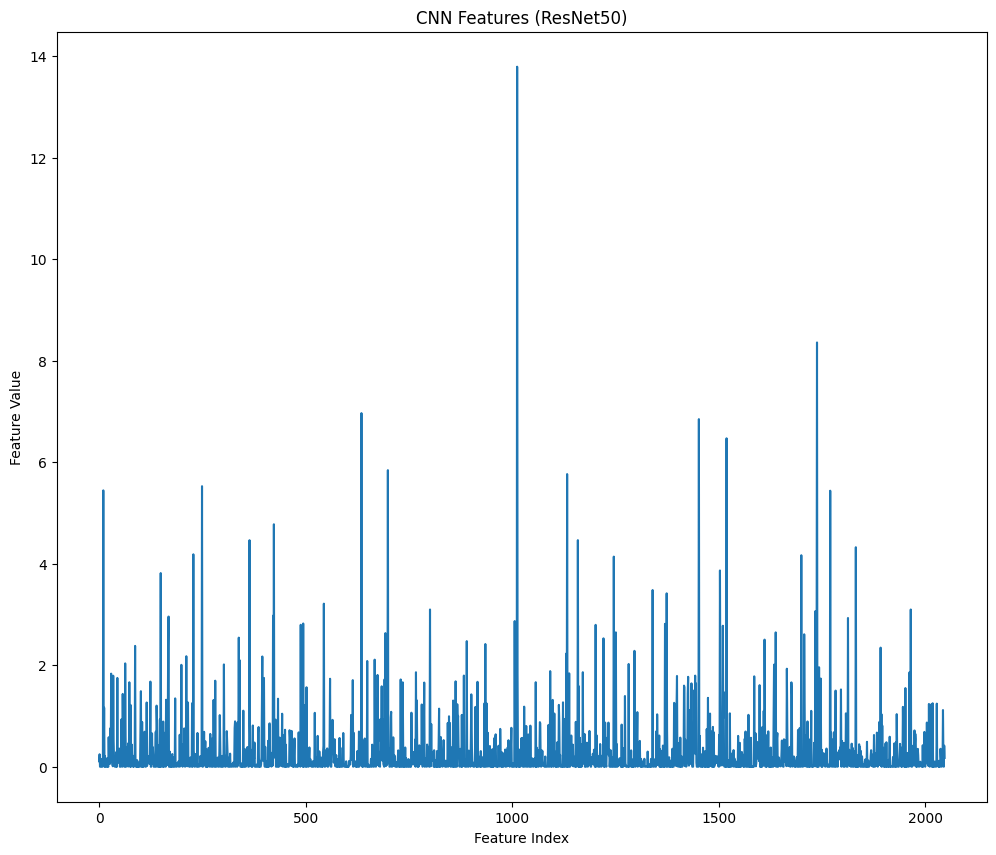

Shape of extracted ResNet features: (2048,)


In [40]:
resnet_features = extract_resnet_features(img_path)

# Plot the extracted ResNet features
plt.figure(figsize=(12, 10))
plt.title("CNN Features (ResNet50)")
plt.plot(resnet_features.flatten())
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

# Print the shape of extracted features
print("Shape of extracted ResNet features:", resnet_features.shape)